# 🍇 Wine Recognition - Classification Using Multiple Algorithms
## Goal: Classify wine into 3 classes based on chemical analysis

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import loguniform, randint

## Load and Prepare Data

In [5]:
df_white_wine = pd.read_csv('winequality-white.csv', sep=';')
df_white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
df_white_wine.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1838,6.5,0.34,0.36,11.0,0.052,53.0,247.0,0.99840,3.44,0.55,9.30,6
2259,7.2,0.39,0.54,1.4,0.157,34.0,132.0,0.99449,3.11,0.53,9.00,6
4494,7.5,0.24,0.29,1.1,0.046,34.0,84.0,0.99020,3.04,0.39,11.45,6
3646,7.2,0.33,0.22,4.5,0.031,10.0,73.0,0.99076,2.97,0.52,12.20,7
2692,6.9,0.31,0.32,1.2,0.024,20.0,166.0,0.99208,3.05,0.54,9.80,6


In [7]:
df_white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Exploratory Data Analysis (EDA) and Visualization


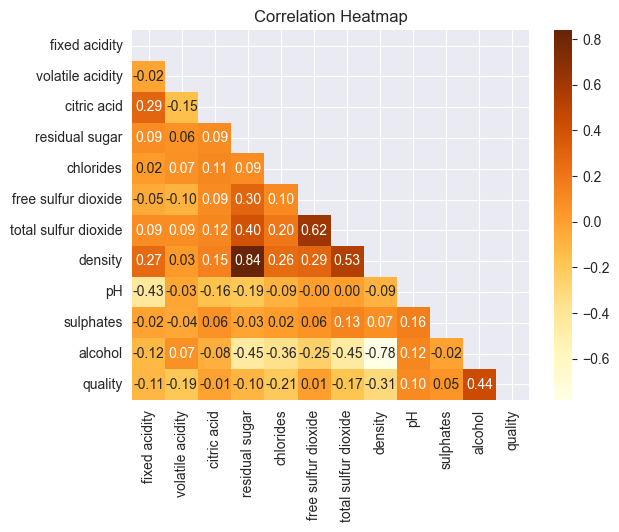

In [9]:
sns.heatmap(df_white_wine.corr(), annot=True, fmt=".2f", mask=np.triu(df_white_wine.corr()), cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

##### From the heatmap, we can observe that 'alcohol' has a strong positive correlation with 'quality', while 'density' and 'residual sugar' have a negative correlation with 'quality'. These insights can guide feature selection for our classification models.

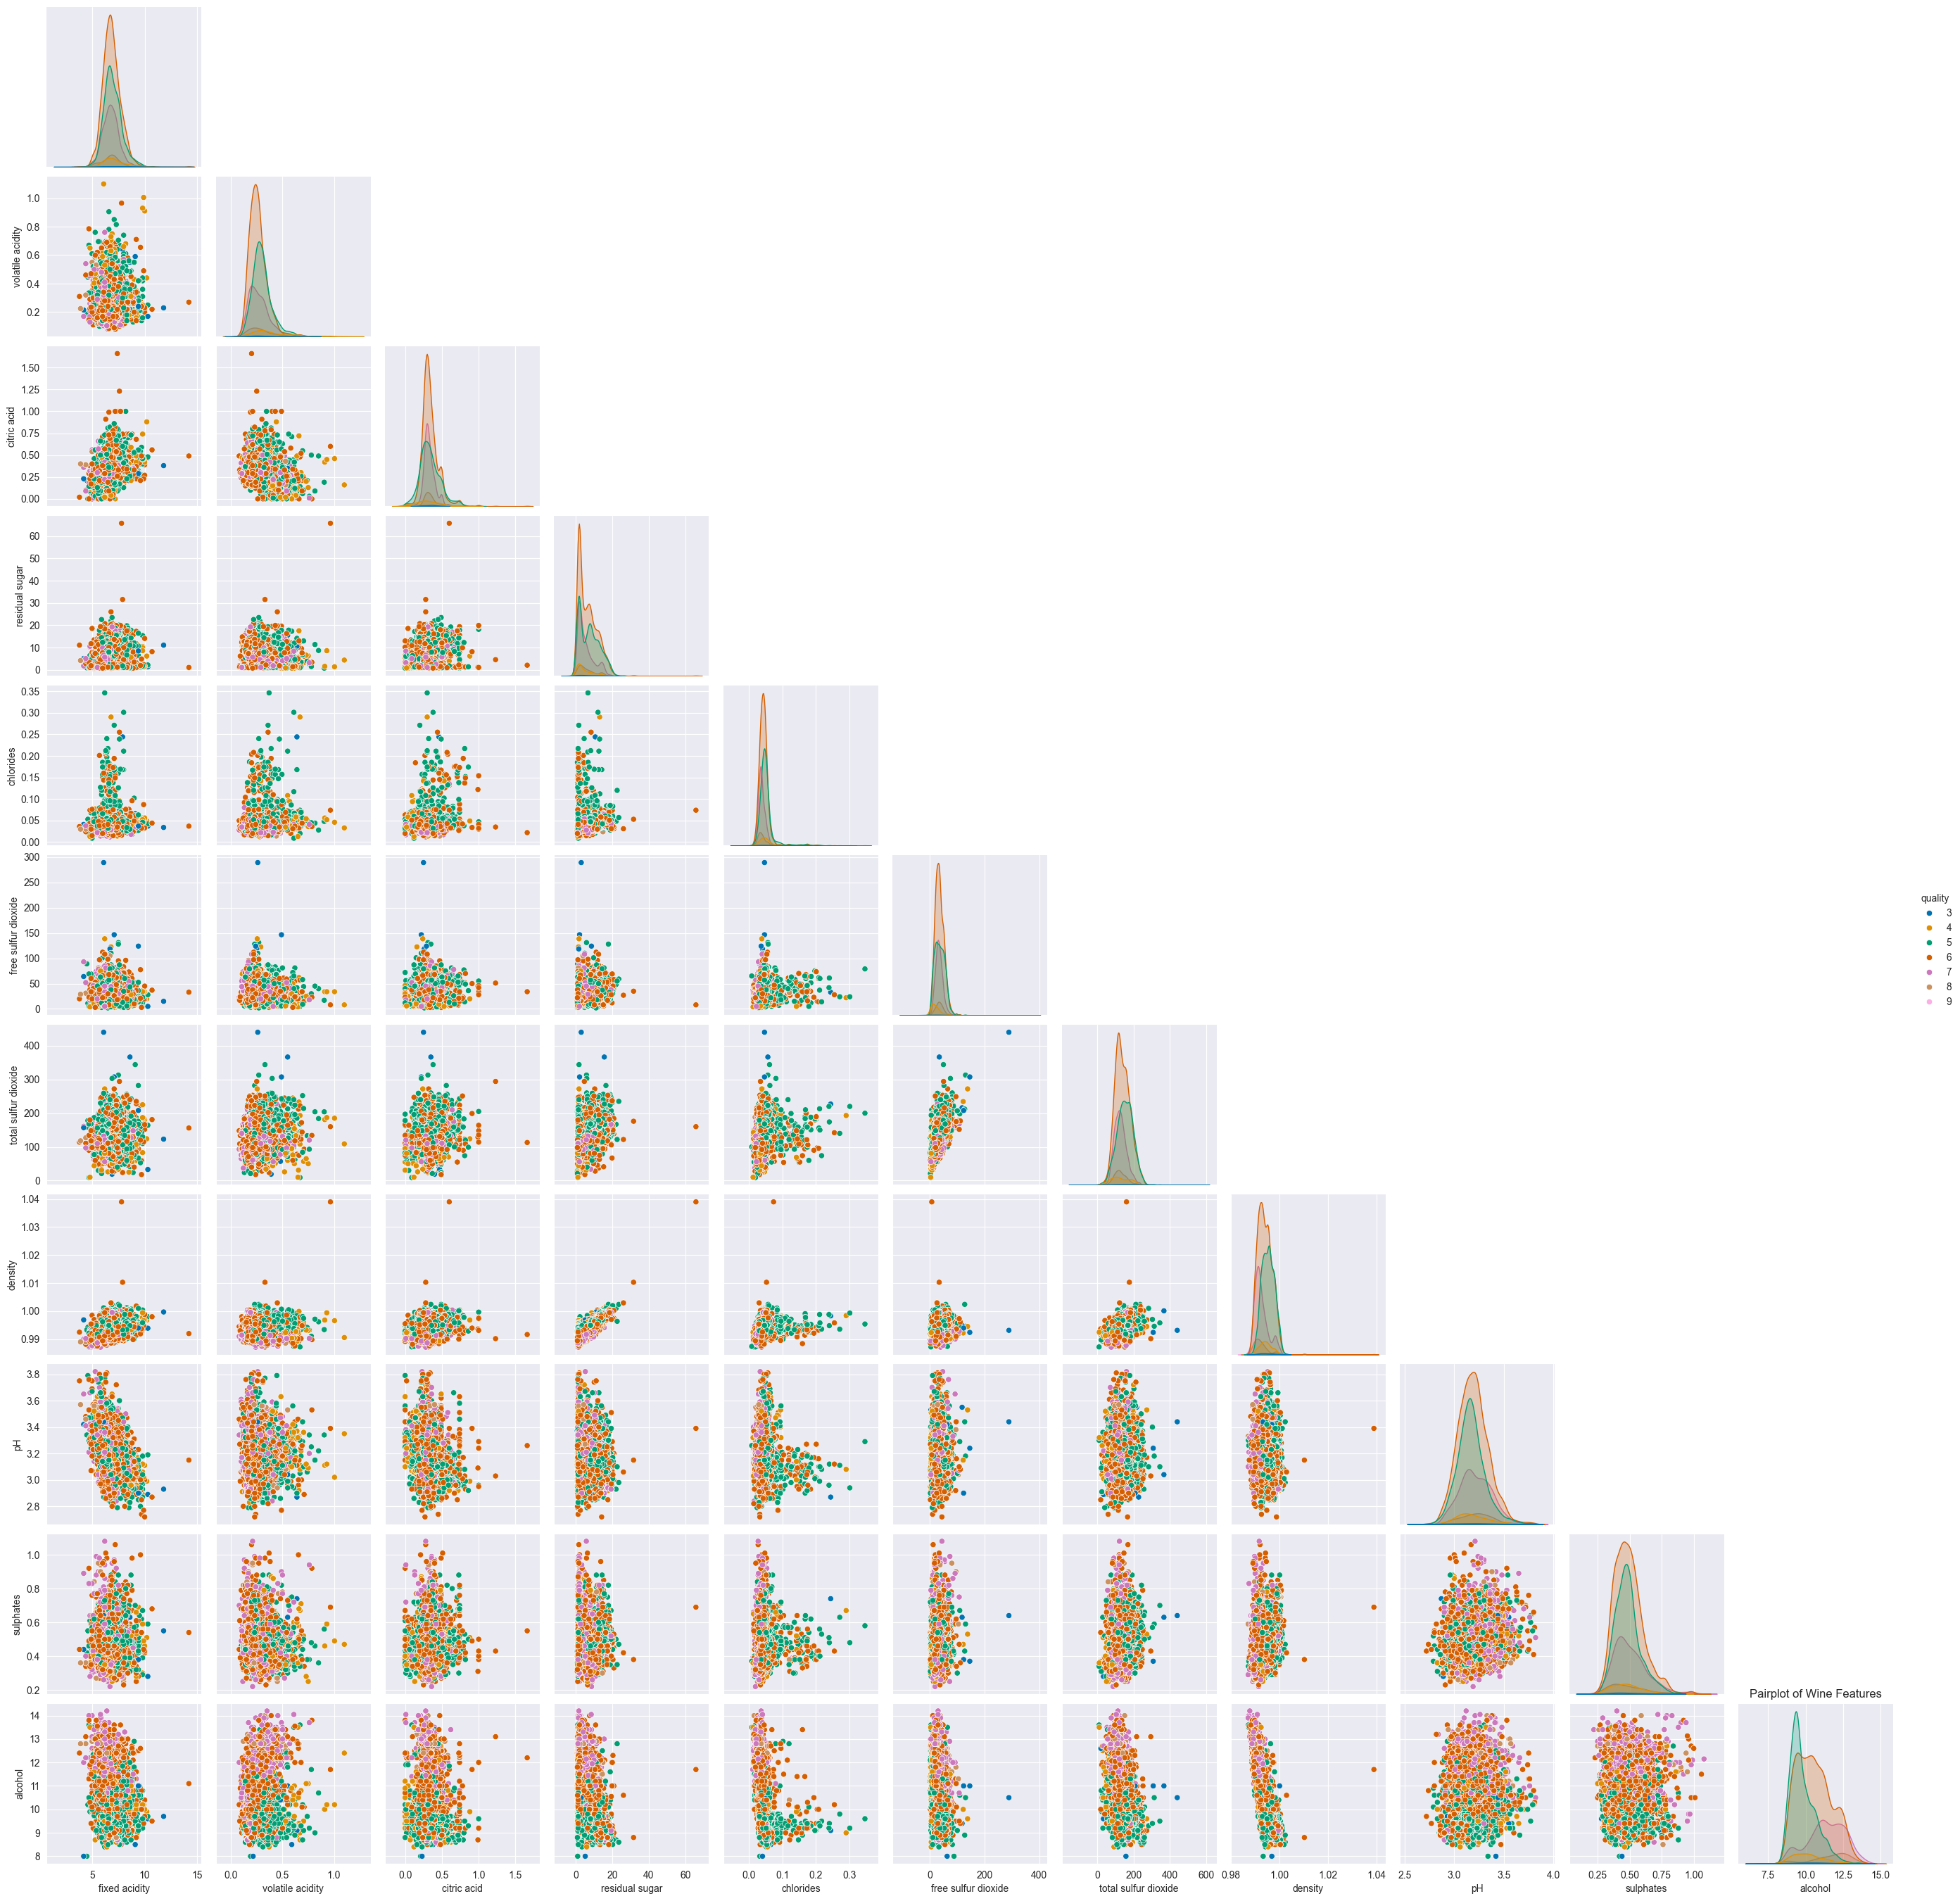

In [10]:
sns.pairplot(df_white_wine, hue='quality', corner=True, palette= "colorblind")
plt.title('Pairplot of Wine Features')
plt.show()

##### The pairplot shows the relationships between different features and how they vary with wine quality. We can see that certain features like 'alcohol' and 'volatile acidity' have distinct distributions for different quality levels.

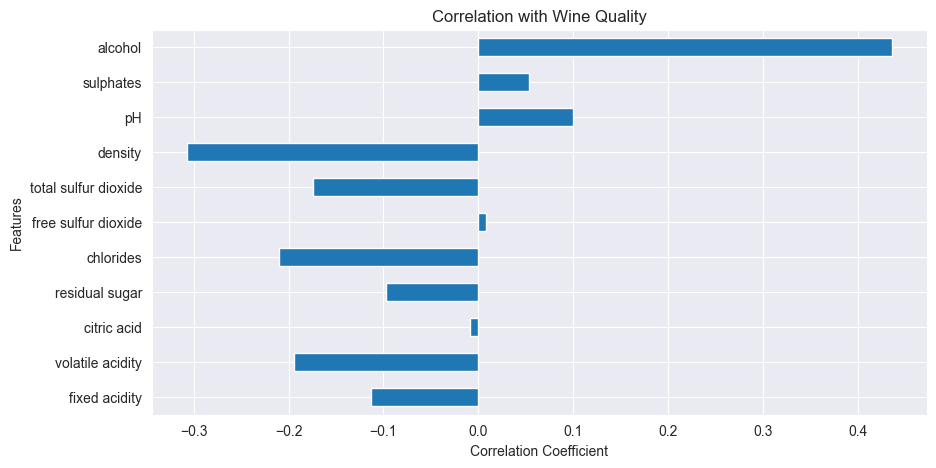

In [11]:
quality_correlation = df_white_wine.corr()["quality"].drop("quality")
quality_correlation.plot(kind="barh", figsize=(10,5), title="Correlation with Wine Quality")
plt.ylabel("Features")
plt.xlabel("Correlation Coefficient")
plt.show()

##### The bar plot highlights the correlation of each feature with wine quality. Features like 'alcohol' and 'density' show significant correlations, which can be useful for our classification models, wile others like 'free sulfur dioxide' and 'citric acid' show weaker correlations.

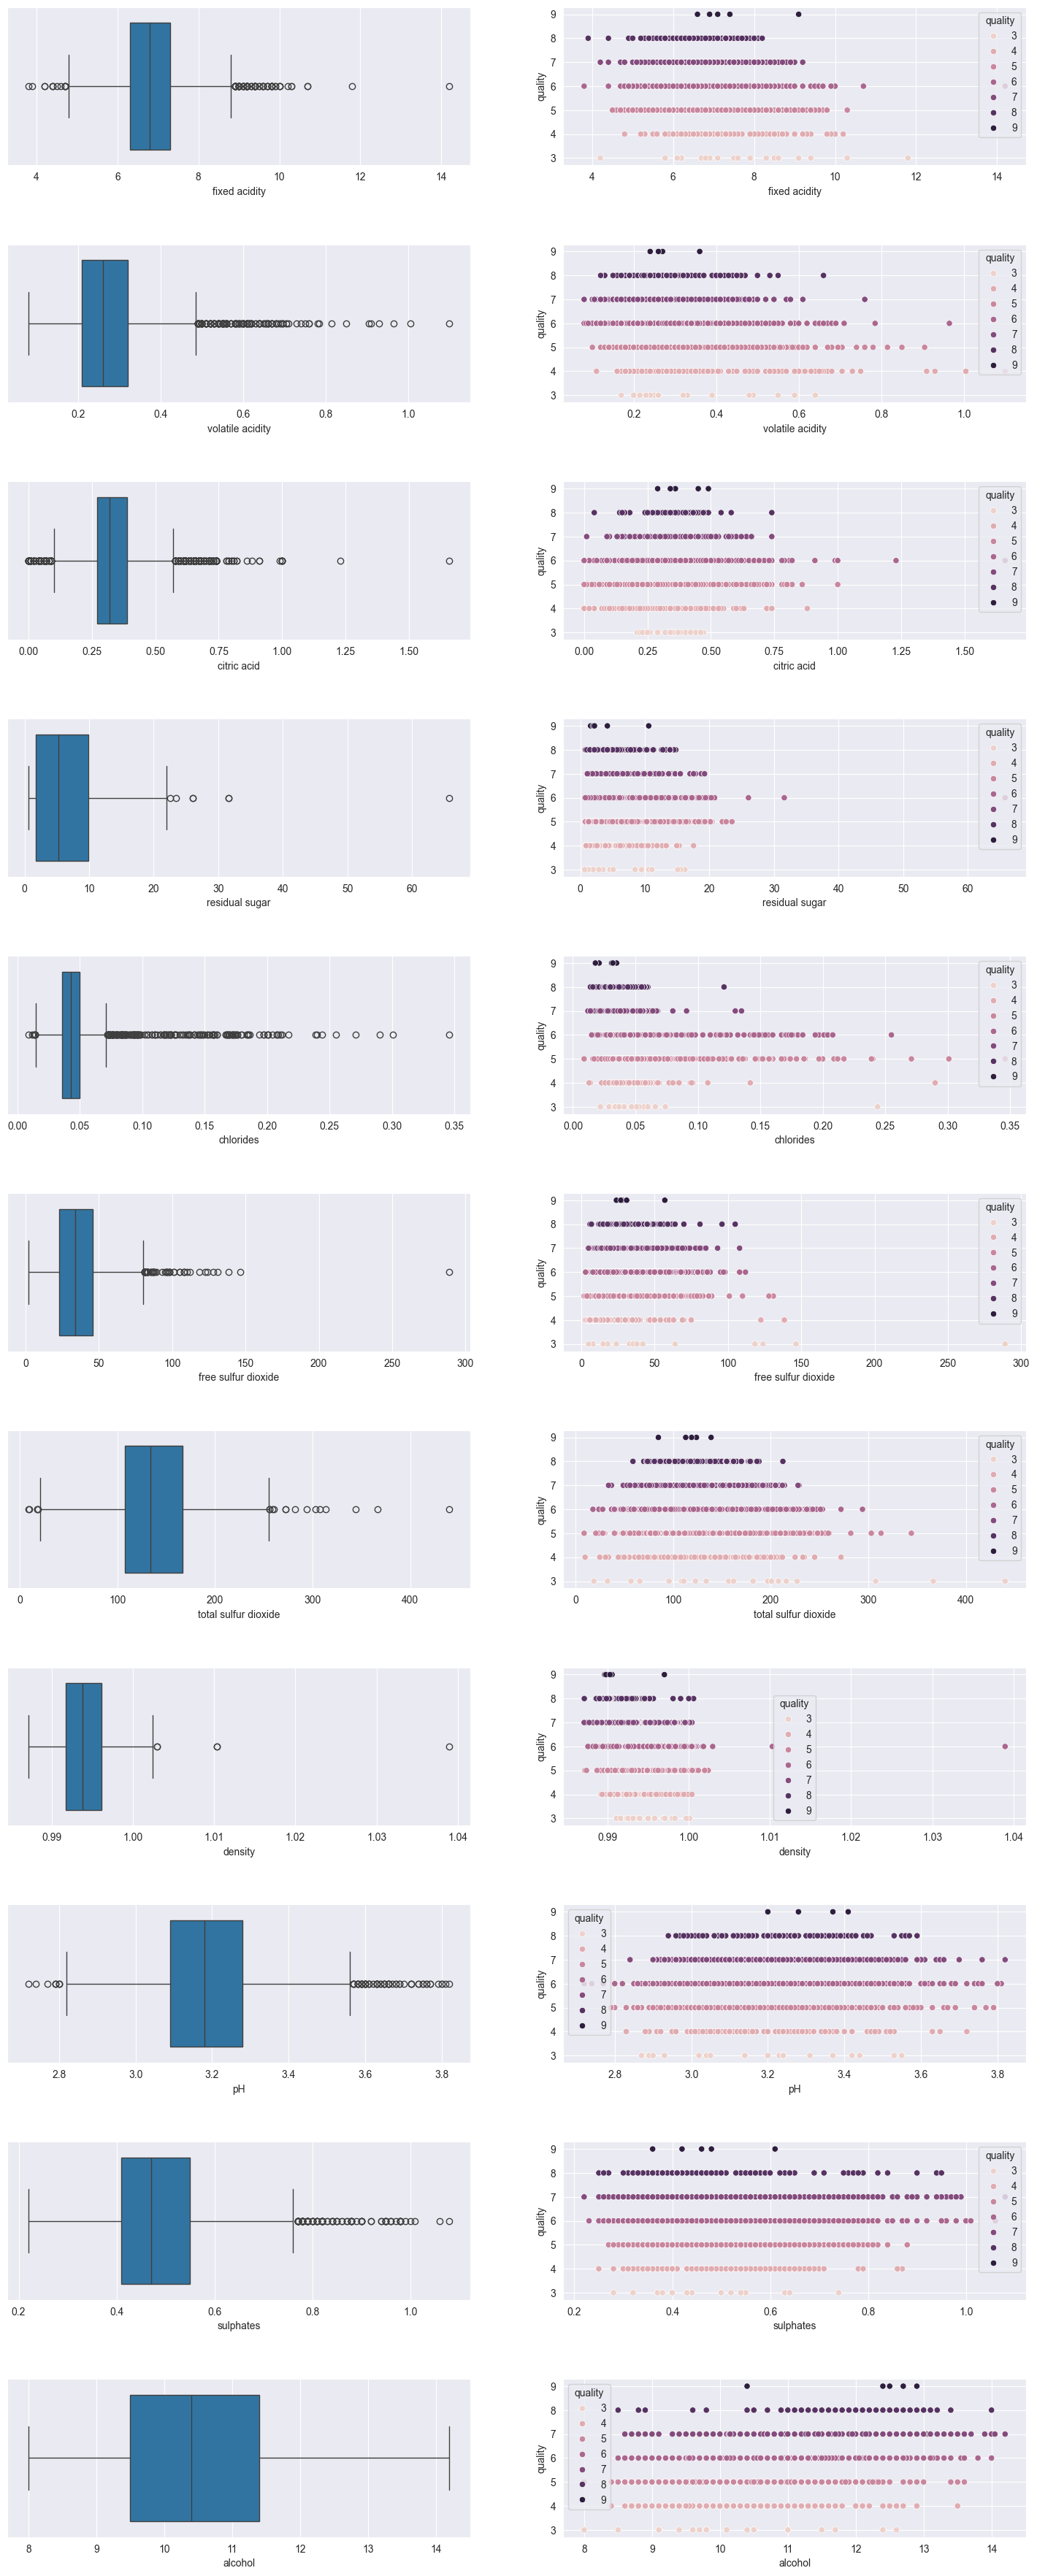

In [12]:
fig, ax = plt.subplots(11,2, figsize=(18,45))
plt.subplots_adjust(hspace=0.5)
for i in range (11):
    #1st column
    sns.boxplot(x=df_white_wine.columns[i], data=df_white_wine, ax=ax[i,0])
    #2nd column
    sns.scatterplot(x=df_white_wine.columns[i], y=df_white_wine["quality"], data=df_white_wine, hue="quality", ax=ax[i,1])
plt.show()

##### The box-plots and scatter-plots provide insights into the distribution of each feature and its relationship with wine quality. For instance, 'alcohol' shows a clear trend where higher alcohol content is associated with higher quality scores.

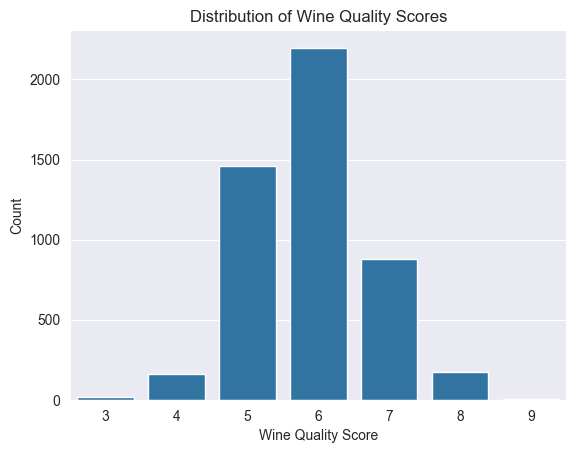

In [53]:
sns.countplot(x='quality', data=df_white_wine)
plt.title('Distribution of Wine Quality Scores')
plt.xlabel('Wine Quality Score')
plt.ylabel('Count')
plt.show()

##### The wine quality dataset is heavily imbalanced. The majority of wines are rated 5, 6, and 7, while classes such as 3 and 9 have 25 samples combined.

##### This imbalance poses two challenges:

* Model bias: A classifier trained on the raw data will tend to predict only the majority classes (5–7), ignoring minority classes.

* Unreliable resampling: Oversampling methods like SMOTE require enough minority samples to generate synthetic neighbors. With only 5–20 samples, synthetic samples are unlikely to represent realistic wines.

### Data Preprocessing

In [60]:
# Defining features and target variable
X = df_white_wine.loc[:, df_white_wine.columns != 'quality']
y = df_white_wine['quality']

In [61]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


##### To improve both model performance and interpretability, we reframe the task into fewer, more balanced categories:

* Binary classification: Good wine (≥7) vs. Not good (<7)

* 3-class classification: Low (≤4), Medium (5–6), High (≥7)

##### This approach is commonly used in imbalanced classification problems. It reduces the noise from extremely rare classes while still capturing meaningful differences in wine quality.

In [62]:
y = y.replace({
    9 : 'Good',
    8 : 'Good',
    7 : 'Good',
    6 : 'Moderate',
    5 : 'Moderate',
    4 : 'Bad',
    3 : 'Bad',
})

y.unique()


array(['Moderate', 'Good', 'Bad'], dtype=object)

##### After reclassification, class distributions become more balanced, enabling fairer model training and evaluation. Performance will be measured using balanced accuracy and macro F1-score, which treat each class equally, rather than standard accuracy which is dominated by majority classes.

### Splitting the Data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Principal Component Analysis (PCA) for Dimensionality Reduction and CV

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=9)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#### Defining functions to plot confusion matrix and classification report

In [66]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to plot classification report
def plot_classification_report(y_test, y_pred, title):
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10,6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title(f'Classification Report - {title}')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

# Cross-Validation Report


## Model Training and Evaluation

### Random Forest Classifier

In [67]:
rf_parameters = {
    'classifier__n_estimators' : randint(100, 500), # Integers only
    'classifier__max_depth' : randint(3,20),
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 4],
    'classifier__max_features' : ['sqrt', 'log2']
}

#### Implementing Imbalance Pipeline + SMOTE / RandomOverSampler

In [68]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

imb_pipeline = ImbPipeline([
    ('smote', SMOTE( k_neighbors=1, random_state=0)),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('classifier', RandomForestClassifier(random_state=0))
])

In [69]:
rf_smote_grid = HalvingRandomSearchCV(
    imb_pipeline,
    param_distributions = rf_parameters,
    factor = 3,
    max_resources = 'auto',
    cv=cv,
    n_jobs=-1,
    random_state=0,
    scoring='balanced_accuracy',
    error_score='raise',
)

try:
    rf_smote_grid.fit(X_train, y_train)
except ValueError as e:
    print("SMOTE failed, switching to RandomOverSampler", e)

    #Fallback to RandomOverSampler
    fallback_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('pca', pca),
        ('smote', RandomOverSampler(random_state=0)),
        ('classifier', RandomForestClassifier(random_state=0))
    ])
    rf_smote_ros = HalvingRandomSearchCV(
        fallback_pipeline,
        param_distributions=rf_parameters,
        cv=cv,
        factor = 3,
        max_resources = 'auto',
        n_jobs=-1,
        random_state=0,
        scoring='balanced_accuracy',
        error_score='raise',
    )

    rf_smote_ros.fit(X_train, y_train)

SMOTE failed, switching to RandomOverSampler Expected n_neighbors <= n_samples_fit, but n_neighbors = 2, n_samples_fit = 1, n_samples = 1


In [70]:
print("Best Score", rf_smote_ros.best_score_)

Best Score 0.6159046327964298


Balanced Accuracy Scores:
None: 0.434
RandomOverSampler: 0.464
RandomUnderSampler: 0.654
SMOTE: 0.494
SMOTEENN: 0.574
SMOTETomek: 0.498


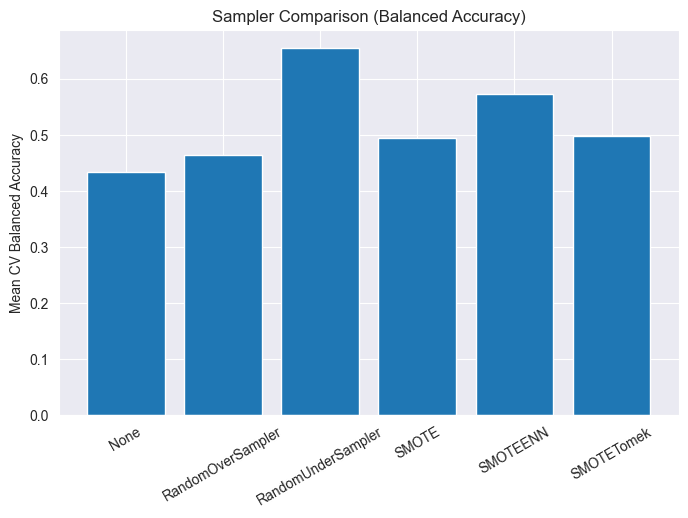

In [71]:
# Define samplers to test
samplers = {
    "None": None,
    "RandomOverSampler": RandomOverSampler(random_state=0),
    "RandomUnderSampler": RandomUnderSampler(random_state=0),
    "SMOTE": SMOTE(k_neighbors=1, random_state=0),
    "SMOTEENN": SMOTEENN(smote=SMOTE(k_neighbors=1, random_state=0),random_state=0),
    "SMOTETomek": SMOTETomek(smote=SMOTE(k_neighbors=1,random_state=0),random_state=0),
}

results = {}

# Evaluate each sampler with cross-validation
for name, sampler in samplers.items():
    steps = [('scaler', StandardScaler())]
    if sampler is not None:
        steps.append(('sampler', sampler))
    steps.append(('classifier', RandomForestClassifier(random_state=0)))

    pipeline = ImbPipeline(steps)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='balanced_accuracy')
    results[name] = scores.mean()

# Show results
print("Balanced Accuracy Scores:")
for k, v in results.items():
    print(f"{k}: {v:.3f}")

# Plot results
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values())
plt.title("Sampler Comparison (Balanced Accuracy)")
plt.ylabel("Mean CV Balanced Accuracy")
plt.xticks(rotation=30)
plt.show()
